# The easy approach for GAN nn.

GAN的简单实现
下面是一个最简化的使用Keras实现的GAN，基于CelebA数据集。

Dataset Download link(kaggle):[https://www.kaggle.com/jessicali9530/celeba-dataset](https://www.kaggle.com/jessicali9530/celeba-dataset)

model的定义：

1. 定义discriminator，然后compile；
2. 定义generator，不进行compile；
3. 定义一个model包含generator和discriminator，把discriminator设为not trainable，然后compile：

![Easy_Approach.png](./src/Easy_Approach.png)

训练loop：

从训练集选择R张图像；
1. 采样大小为N的随机噪声，输入generator产生F张fake的图像；
2. 将R张训练集与F张fake图像和对应的label输入discriminator进行训练；
3. 采样大小为N的随机噪声；
4. 用train_on_batch，以目标label为1对generator进行训练更新。

source: [知乎-如何形象又有趣的讲解对抗神经网络（GAN）是什么?](https://www.zhihu.com/question/63493495)

Imports：

In [34]:
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.python.keras.layers.convolutional import Deconvolution2D
# from tensorflow.keras.datasets import cifar10
import glob, cv2, os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import clear_output

Global Parameters：

In [35]:
SPATIAL_DIM = 64 # Spatial dimensions of the images.
LATENT_DIM = 100 # Dimensionality of the noise vector.
BATCH_SIZE = 32 # Batchsize to use for training.
DISC_UPDATES = 1  # Number of discriminator updates per training iteration.
GEN_UPDATES = 1 # Nmber of generator updates per training iteration.

FILTER_SIZE = 5 # Filter size to be applied throughout all convolutional layers.
NUM_LOAD = 1000 # Number of images to load from CelebA. Fit also according to the available memory on your machine.
NET_CAPACITY = 16 # General factor to globally change the number of convolutional filters.

PROGRESS_INTERVAL = 80 # Number of iterations after which current samples will be plotted.
ROOT_DIR = 'visualization' # Directory where generated samples should be saved to.
DATASET_DIR = "/Users/lishuyu/PycharmProjects/datasets" # Directory where the dataset is

if not os.path.isdir(ROOT_DIR):
    os.mkdir(ROOT_DIR)

数据预处理

- 对所有训练的image做normalize处理

((1000, 64, 64, 3), -1.0, 1.0)

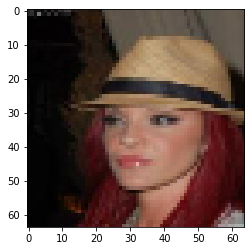

In [36]:
def plot_image(x):
    plt.imshow(x * 0.5 + 0.5)
X = []
# Reference to CelebA dataset here. I recommend downloading from the Harvard 2019 ComputeFest GitHub page (there is also some good coding tutorials here)
faces = glob.glob(f'{DATASET_DIR}/CelebA/img_align_celeba/*.jpg')

for i, f in enumerate(faces):
    img = cv2.imread(f)
    img = cv2.resize(img, (SPATIAL_DIM, SPATIAL_DIM))
    img = np.flip(img, axis=2)
    img = img.astype(np.float32) / 127.5 - 1.0
    X.append(img)
    if i >= NUM_LOAD - 1:
        break
X = np.array(X)
plot_image(X[4])
X.shape, X.min(), X.max()

定义架构

将block抽象单独定义出来能让代码更简洁。padding方法选择"same":

In [37]:
def add_encoder_block(x, filters, filter_size):
    x = Conv2D(filters, filter_size, padding='same')(x)
    x = BatchNormalization()(x)
    x = Conv2D(filters, filter_size, padding='same', strides=2)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

使用encoder_block定义discriminator，循环使用encoder block，并不断增大filter size：

In [38]:



def build_discriminator(start_filters, spatial_dim, filter_size):
    inp = Input(shape=(spatial_dim, spatial_dim, 3))

    # Encoding blocks downsample the image.
    x = add_encoder_block(inp, start_filters, filter_size)
    x = add_encoder_block(x, start_filters * 2, filter_size)
    x = add_encoder_block(x, start_filters * 4, filter_size)
    x = add_encoder_block(x, start_filters * 8, filter_size)

    x = GlobalAveragePooling2D()(x)
    x = Dense(1, activation='sigmoid')(x)
    return keras.Model(inputs=inp, outputs=x)

下面定义decoder block，主要做反卷积：

In [39]:

def add_decoder_block(x, filters, filter_size):
    x = Deconvolution2D(filters, filter_size, strides=2, padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(0.3)(x)
    return x

下面定义generator，循环使用decoder block并不断降低filter size:

In [40]:
def build_generator(start_filters, filter_size, latent_dim):
    inp = Input(shape=(latent_dim,))

    # Projection.
    x = Dense(4 * 4 * (start_filters * 8), input_dim=latent_dim)(inp)
    x = BatchNormalization()(x)
    x = Reshape(target_shape=(4, 4, start_filters * 8))(x)

    # Decoding blocks upsample the image.
    x = add_decoder_block(x, start_filters * 4, filter_size)
    x = add_decoder_block(x, start_filters * 2, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)
    x = add_decoder_block(x, start_filters, filter_size)

    x = Conv2D(3, kernel_size=5, padding='same', activation='tanh')(x)
    return keras.Model(inputs=inp, outputs=x)

训练

构建网络和训练流程 构建GAN时，定义discriminator为not trainable是非常重要的。因为我们不能同时训练两个网络，就像我们不能校正多个同时变化的东西。所以在训练某一个网络时，需要保持其他部分是固定不变的。

In [41]:
def construct_models(verbose=False):
    # 1. Build discriminator.
    discriminator = build_discriminator(NET_CAPACITY, SPATIAL_DIM, FILTER_SIZE)
    discriminator.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    # 2. Build generator.
    generator = build_generator(NET_CAPACITY, FILTER_SIZE, LATENT_DIM)

    # 3. Build full GAN setup by stacking generator and discriminator.
    gan = keras.Sequential()
    gan.add(generator)
    gan.add(discriminator)
    discriminator.trainable = False # Fix the discriminator part in the full setup.
    gan.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0002), metrics=['mae'])

    if verbose: # Print model summaries for debugging purposes.
        generator.summary()
        discriminator.summary()
        gan.summary()
    return generator, discriminator, gan

- 模型训练：

In [42]:
def run_training(start_it=0,num_epochs=1000):
    # Save configuration file with global parameters
    config_name = 'gan_cap' + str(NET_CAPACITY) + '_batch' + str(BATCH_SIZE) + '_filt' + str(FILTER_SIZE) + '_disc' + str(DISC_UPDATES) + '_gen' + str(GEN_UPDATES)
    folder = os.path.join(ROOT_DIR, config_name)
    if not os.path.isdir(folder):
        os.mkdir(folder)

    # Initiate loop variables
    avg_loss_discriminator = []
    avg_loss_generator = []
    total_it = start_it

    # Start of training loop
    for epoch in range(num_epochs):
        loss_discriminator = []
        loss_generator = []
        for it in range(200):
            # Update discriminator.
            for i in range(DISC_UPDATES):
                # Fetch real examples (you could sample unique entries, too).
                imgs_real = X[np.random.randint(0, X.shape[0], size=BATCH_SIZE)]
                # Generate fake examples.
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                imgs_fake = generator.predict(noise)

                d_loss_real = discriminator.train_on_batch(imgs_real, np.ones([BATCH_SIZE]))[1]
                d_loss_fake = discriminator.train_on_batch(imgs_fake, np.zeros([BATCH_SIZE]))[1]

            # Progress visualizations.
            if total_it % PROGRESS_INTERVAL == 0:
                plt.figure(figsize=(5,2))
                # We sample separate images.
                num_vis = min(BATCH_SIZE, 8)
                imgs_real = X[np.random.randint(0, X.shape[0], size=num_vis)]
                noise = np.random.randn(num_vis, LATENT_DIM)
                imgs_fake = generator.predict(noise)
                for obj_plot in [imgs_fake, imgs_real]:
                    plt.figure(figsize=(num_vis * 3, 3))
                    for b in range(num_vis):
                        disc_score = float(discriminator.predict(np.expand_dims(obj_plot[b], axis=0))[0])
                        plt.subplot(1, num_vis, b + 1)
                        plt.title(str(round(disc_score, 3)))
                        plot_image(obj_plot[b])
                    if obj_plot is imgs_fake:
                        plt.savefig(os.path.join(folder, str(total_it).zfill(10) + '.jpg'), format='jpg', bbox_inches='tight')
                    plt.show()

            # update generator.
            loss = 0
            y = np.ones([BATCH_SIZE, 1])
            for j in range(GEN_UPDATES):
                noise = np.random.randn(BATCH_SIZE, LATENT_DIM)
                loss += gan.train_on_batch(noise, y)[1]

            loss_discriminator.append((d_loss_real + d_loss_fake) / 2.)
            loss_generator.append(loss / GEN_UPDATES)
            total_it += 1

        # Progress visualization.
        clear_output(True)
        print('Epoch', epoch)
        avg_loss_discriminator.append(np.mean(loss_discriminator))
        avg_loss_generator.append(np.mean(loss_generator))
        plt.plot(range(len(avg_loss_discriminator)), avg_loss_discriminator)
        plt.plot(range(len(avg_loss_generator)), avg_loss_generator)
        plt.legend(['discriminator loss', 'generator loss'])
        plt.show()

跑模型：

Epoch 14


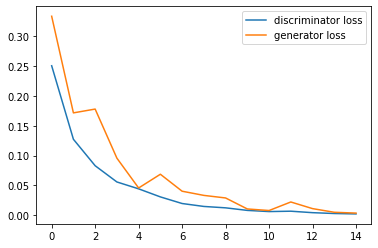

<Figure size 360x144 with 0 Axes>

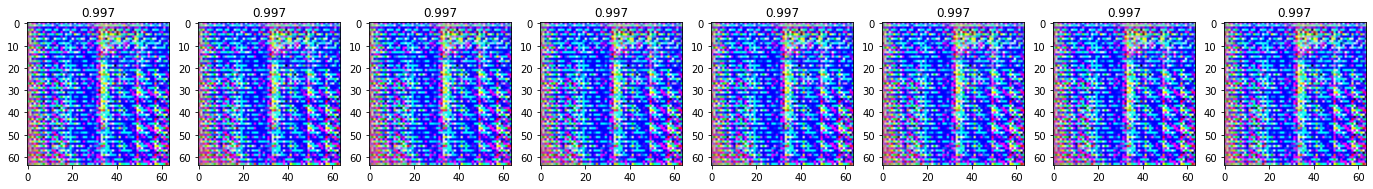

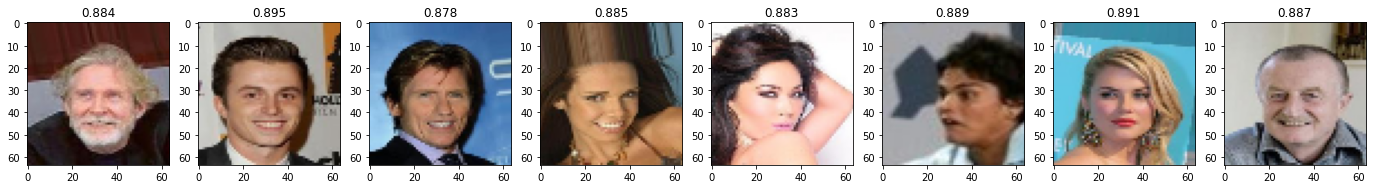

Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7fd92e4cd8b0>
Traceback (most recent call last):
  File "/Users/lishuyu/.conda/envs/nn_v0.1/lib/python3.8/site-packages/tensorflow/python/data/ops/iterator_ops.py", line 545, in __del__
    gen_dataset_ops.delete_iterator(
  File "/Users/lishuyu/.conda/envs/nn_v0.1/lib/python3.8/site-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1263, in delete_iterator
    _result = pywrap_tfe.TFE_Py_FastPathExecute(
KeyboardInterrupt: 


KeyboardInterrupt: 

In [43]:
generator, discriminator, gan = construct_models(verbose=True)
run_training()

训练结果：

In [ ]:
NUM_SAMPLES = 7
plt.figure(figsize=(NUM_SAMPLES * 3, 3))

for i in range(NUM_SAMPLES):
    noise = np.random.randn(1, LATENT_DIM)
    pred_raw = generator.predict(noise)[0]
    pred = pred_raw * 0.5 + 0.5
    plt.subplot(1, NUM_SAMPLES, i + 1)
    plt.imshow(pred)
plt.show()